## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [ ]:
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
with open('sonnets.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2205

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = "".join(text)
text = text.lower()

assert len(text) == 80570, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(list(set(text)))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
# Your great code here
idx_to_token = {idx: char for idx, char in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {char: idx for idx, char in enumerate(tokens)}
VOCAB_SIZE = len(tokens)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
text_as_indices = np.array([token_to_idx[char] for char in text])
SEQ_LENGTH = 40

In [ ]:
class SonnetDataset(Dataset):
    def __init__(self, text_indices, seq_length):
        self.text_indices = text_indices
        self.seq_length = seq_length

    def __len__(self):
        return len(self.text_indices) - self.seq_length

    def __getitem__(self, idx):
        x = self.text_indices[idx : idx + self.seq_length]
        y = self.text_indices[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

dataset = SonnetDataset(text_as_indices, SEQ_LENGTH)
batch_size = 128
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
EMBEDDING_DIM = 128
HIDDEN_SIZE = 256

class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)

        logits = self.fc(out[:, -1, :])
        return logits, hidden

    def initial_state(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

model = CharRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE)
print(model)

CharRNN(
  (embedding): Embedding(38, 128)
  (rnn): RNN(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=38, bias=True)
)


Plot the loss function (axis X: number of epochs, axis Y: loss function).

Epoch 1/20, Loss: 2.0215
Epoch 2/20, Loss: 1.7606
Epoch 3/20, Loss: 1.6645
Epoch 4/20, Loss: 1.6040
Epoch 5/20, Loss: 1.5566
Epoch 6/20, Loss: 1.5194
Epoch 7/20, Loss: 1.4889
Epoch 8/20, Loss: 1.4614
Epoch 9/20, Loss: 1.4356
Epoch 10/20, Loss: 1.4147
Epoch 11/20, Loss: 1.3934
Epoch 12/20, Loss: 1.3734
Epoch 13/20, Loss: 1.3558
Epoch 14/20, Loss: 1.3370
Epoch 15/20, Loss: 1.3206
Epoch 16/20, Loss: 1.3045
Epoch 17/20, Loss: 1.2888
Epoch 18/20, Loss: 1.2740
Epoch 19/20, Loss: 1.2610
Epoch 20/20, Loss: 1.2464


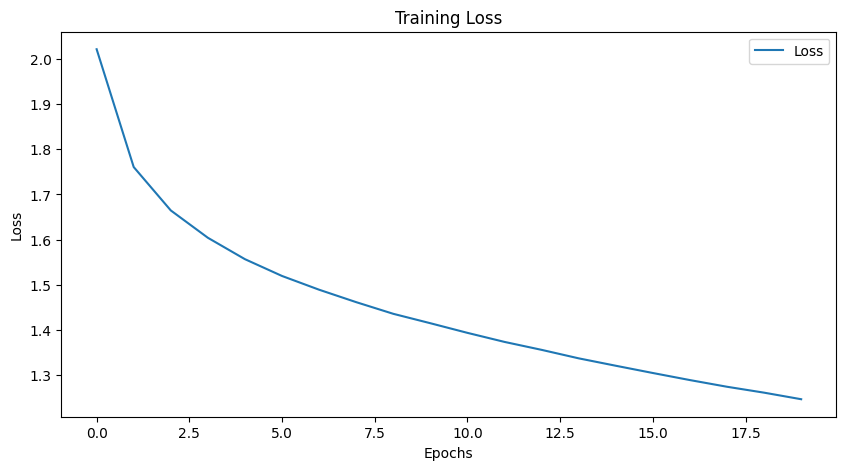

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

num_epochs = 20
history_loss = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()

        # Прямой проход (forward)
        logits, _ = model(x_batch)
        loss = criterion(logits, y_batch)

        # Обратный проход (backward)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    history_loss.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(history_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [71]:
def generate_sample(char_rnn, seed_phrase=' Hello', max_length=500, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function

    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
        smaller temperature converges to the single most likely output.

    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''

    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        #print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        #print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]

        # sample next token and push it back into x_sequence
        #print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        #print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [72]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

print(generate_sample(model, seed_phrase='hide my will in thine?', max_length=500, temperature=0.5))

hide my will in thine?
o! leave thou from this gives to give thee beauty and this hold, nor thine, for still thine eyes beauty is my friend, and this hold this spirit of thine an others where which for my love, then thou mayst from this write,
whose first this should this genered too ere thine eyes beauty give their gifter thine eyes so thine eyes be the world thine eyes thine eye are free is thine eyes be fair which should to this thin the fair, though this shall giver thine excessing of this h


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [73]:
class LSTMState(tuple):
    @property
    def shape(self):
        # Возвращаем форму первого тензора (h), чтобы удовлетворить print внутри функции
        return self[0].shape

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        if x.dim() == 1:
            x = x.unsqueeze(1)
        x = self.embedding(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out[:, -1, :])
        # Оборачиваем скрытое состояние в наш класс с атрибутом .shape
        return logits, LSTMState(hidden)

    def initial_state(self, batch_size):
        # Оборачиваем начальное состояние в наш класс
        h_0 = torch.zeros(1, batch_size, self.hidden_size)
        c_0 = torch.zeros(1, batch_size, self.hidden_size)
        return LSTMState((h_0, c_0))

# Создаем модель заново
model_lstm = CharLSTM(VOCAB_SIZE, 128, 256)

In [74]:
# Your beautiful code here
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(CharLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # Используем LSTM вместо RNN
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        x = self.embedding(x)
        # LSTM возвращает (h, c) в качестве hidden state
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out[:, -1, :])
        return logits, hidden

    def initial_state(self, batch_size):
        # Для LSTM начальное состояние — это кортеж из двух тензоров (h_0, c_0)
        return (torch.zeros(1, batch_size, self.hidden_size),
                torch.zeros(1, batch_size, self.hidden_size))

# Создаем модель
model_lstm = CharLSTM(VOCAB_SIZE, 128, 256)
print(model_lstm)

CharLSTM(
  (embedding): Embedding(38, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=38, bias=True)
)


Epoch 1/20, LSTM Loss: 1.9654
Epoch 2/20, LSTM Loss: 1.6837
Epoch 3/20, LSTM Loss: 1.5639
Epoch 4/20, LSTM Loss: 1.4870
Epoch 5/20, LSTM Loss: 1.4272
Epoch 6/20, LSTM Loss: 1.3762
Epoch 7/20, LSTM Loss: 1.3288
Epoch 8/20, LSTM Loss: 1.2844
Epoch 9/20, LSTM Loss: 1.2420
Epoch 10/20, LSTM Loss: 1.1998
Epoch 11/20, LSTM Loss: 1.1586
Epoch 12/20, LSTM Loss: 1.1159
Epoch 13/20, LSTM Loss: 1.0768
Epoch 14/20, LSTM Loss: 1.0347
Epoch 15/20, LSTM Loss: 0.9923
Epoch 16/20, LSTM Loss: 0.9513
Epoch 17/20, LSTM Loss: 0.9119
Epoch 18/20, LSTM Loss: 0.8727
Epoch 19/20, LSTM Loss: 0.8331
Epoch 20/20, LSTM Loss: 0.7954


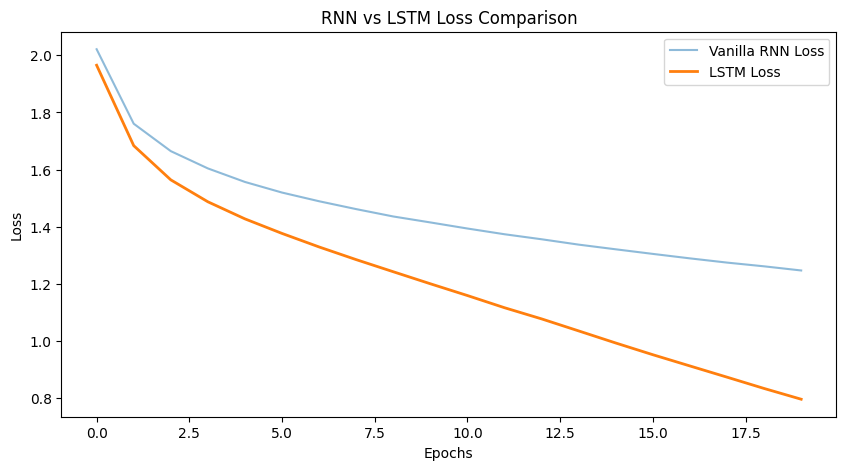

In [77]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model_lstm.parameters(), lr=0.001)

num_epochs = 20
history_loss_lstm = []

for epoch in range(num_epochs):
    model_lstm.train()
    epoch_loss = 0
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()

        logits, _ = model_lstm(x_batch)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    history_loss_lstm.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, LSTM Loss: {avg_loss:.4f}")

# Сравнение графиков
plt.figure(figsize=(10, 5))
plt.plot(history_loss, label='Vanilla RNN Loss', alpha=0.5)
plt.plot(history_loss_lstm, label='LSTM Loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN vs LSTM Loss Comparison')
plt.legend()
plt.show()

In [78]:
print(generate_sample(model_lstm, seed_phrase='hide my will in thine?', max_length=500, temperature=0.5))

hide my will in thine?
for the world will thou wilt, swift-footed still sucher be thy shadow to my spurish shouldst or gentle grace is stronger and so proud mine own drook's some gives that married, so downors all those did pride on my heart;
my gave as fair, which wailing thy show, not east thou good thou art with the warding of this his rider loves i am any want swift, to-day, and all thy sings onery part;
and even i am thy sight upon thy sweet love you do not so so; i so is, the painted bow,



Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [79]:
# Text generation with different temperature values here
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
seed = "hide my will in thine?"

for temp in temperatures:
    print(f"\n--- Temperature: {temp} ---")
    generated = generate_sample(model, seed_phrase=seed.lower(), max_length=500, temperature=temp)
    print(generated)

seed = "hide my will in thine?"

for temp in temperatures:
    print(f"\n--- Temperature: {temp} ---")
    generated = print(generate_sample(model_lstm, seed_phrase='hide my will in thine?', max_length=200, temperature=temp))
    print(generated)


--- Temperature: 0.1 ---
hide my will in thine?
and this this thine eyes be the first this this thoughts and this this thine eyes be the first this thine eyes be the first this this thine eyes in this shall give thee this thine eyes in this thine eyes be the first this thine eyes be the first this thine eyes be the first this this thine eyes the first this this thine eyes be the first this this thine eyes in this shall gives thee this this thine eyes be the first this this shall gives thee this this this thoughts and th

--- Temperature: 0.2 ---
hide my will in thine?
which this thine eyes be the first this this thoughts and this thine eyes be the world this this thine eyes in me thine eyes be the first this shall give thee this this thoughts of this face,
and this this thine eyes are sould this thine eyes be the first this shall give thee this this shall gives thee this thine eyes be the stars thou art thou art this shall i for thine eyes in should not so better thine eyes the world 

1. (0.1 – 0.2): Модель выбирает только самые вероятные символы. Текст очень чистый, без опечаток, но он быстро становится цикличным.У неё нет «фантазии», она боится рисковать.

2. (0.5 – 0.7): Текст выглядит наиболее похожим на человеческий. Слова разнообразны, структура сонета соблюдается, опечаток минимум. Модель создает ощущение живой речи.

3. (1.0): Текст становится более разнообразным, но начинают появляться несуществующие слова. Модель начинает «рисковать», выбирая буквы, в которых она не очень уверена. Это добавляет оригинальности, но снижает грамотность.

4. (2.0): Хаос. Знаки препинания и буквы перемешаны случайным образом. Модели почти всё равно, какую букву выбрать следующей. Логика языка полностью теряется.

Вывод: Оптимальная температура для генерации стихов Шекспира находится в районе 0.6 – 0.8.

В целом LSTM генерирует более осмысленные слова и лучше держит структуру стиха. Vanilla RNN может чаще сбиваться на несуществующие слова.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [80]:
# Saving and loading code here
torch.save(model_lstm.state_dict(), 'shakespear_lstm.pth')

In [81]:
loaded_model = CharLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_SIZE)
loaded_model.load_state_dict(torch.load('shakespear_lstm.pth'))
loaded_model.eval()

CharLSTM(
  (embedding): Embedding(38, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=38, bias=True)
)

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a>
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)